In [1]:
%load_ext autoreload
%autoreload 2
import time
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from estimation_fct import *

In [ ]:
# Load model
from model import ModelClass

model = ModelClass() 

par = model.par
sol = model.sol
sim = model.sim

model.solve()
model.simulate()

In [ ]:
# Prepare data
mean, weights, moments = prepare_data(par)

In [ ]:
# Prepare SMM
theta_names = ("beta", "sigma", "gamma", "mu", "m_input", "r_a")
theta_init = np.array([0.992 , 0.9 , 3.05, 4.592, 12.0, 0.010])

# Original bounds
orig_bounds = [(0.0, 1.0),   # beta
               (0.1, 6.0),   # sigma
               (0.1, 10.0),  # gamma
               (0.0, 10.0),  # mu
               (10.0, 30.0),  # mu
               (0.0, 0.1),   # r_a
               ] 

theta_init_scaled = scale_params(theta_init, orig_bounds)

In [ ]:
# Do SMM
objective = lambda theta: obj_func(theta, theta_names, mean, weights, model, orig_bounds, do_print=True)

res = minimize(
    objective, 
    theta_init_scaled,
    method='nelder-mead',
    bounds=[(0,1)] * len(theta_init_scaled),
    tol=1e-6,
    options={"maxiter":10000}
)


beta=0.992 sigma=0.900 gamma=3.050 mu=4.592 m_input=12.000 r_a=0.010 


c:\Design_retirement\estimation_fct.py:87: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.where(sim_data.ex == 1, sim_data.h, np.nan)[:40]  # Length 70


Error = 10942841325325.808594, Time = 78.1903 seconds
beta=0.958 sigma=0.900 gamma=3.050 mu=4.592 m_input=12.000 r_a=0.010 
idid 8678 time 0 asspre 578.080134455212 ass -15.234971887959109 inc 155678.71602073312 c 156271.88028577046 ex 1.0 h 1.1999996909429629 e 1.0 r 0.0
id 6761 time 0 asspre 850.7644098816194 ass -638.8323588133284 inc 148920.2656823366 c 150403.537378172 ex 1.0 h 1.1999996909429633 e 1.0 r 0.0
id 4423 time 0 asspre 536.0386918873935 ass -1535.8299641840772 inc 130399.68993400616 c 132456.3523528085 ex 1.0 h 1.199999690942963 e 1.0 r 0.0
 9060 time 0 asspre 385.3132805028469 ass -1469.901729050581 inc 144164.6730236714 c 146005.334550759 ex 1.0 h 1.199999690942963 e 1.0 r 0.0
id 4979 time 0 asspre 584.0758552668377 ass -632.3057459873229 inc 150959.0885886616 c 152169.20973698518 ex 1.0 h 1.199999690942963 e 1.0 r 0.0
id 9912 time 0 asspre 835.0963984401335 ass -751.6974504175087 inc 147639.97389057287 c 149219.32519041648 ex 1.0 h 1.1999996909429629 e 1.0 r 0.0
id 9

c:\Design_retirement\estimation_fct.py:87: RuntimeWarning: Mean of empty slice
  avg_h_by_age = np.where(sim_data.ex == 1, sim_data.h, np.nan)[:40]  # Length 70


Error = 44270653500.874146, Time = 93.7714 seconds
beta=0.992 sigma=0.940 gamma=3.050 mu=4.592 m_input=12.000 r_a=0.010 


In [ ]:
# Load the model with calibrated values
theta_names = ("beta", "sigma", "gamma", "mu", "m_input", "r_a")
theta_final = np.array([0.992 , 0.9 , 3.05, 4.592, 12.0, 0.010])
# theta_final = unscale_params(res.x, orig_bounds)
# theta_final = np.array([0.961, 1.127, 2.645, 6.657, 0.009, 0.041])
# theta_final = np.array([0.982, 1.060, 3.877, 7.814, 0.02, 0.009])

for i, name in enumerate(theta_names):
    setattr(model.par, name, theta_final[i])

model.solve()
model.simulate()

C:\Users\B224264\AppData\Local\Temp\ipykernel_20564\2323609480.py:3: RuntimeWarning: Mean of empty slice
  'hours': [np.nanmean(np.where(model.sim.ex == 1, model.sim.h, np.nan),axis=0)[:40], moments['hours']],


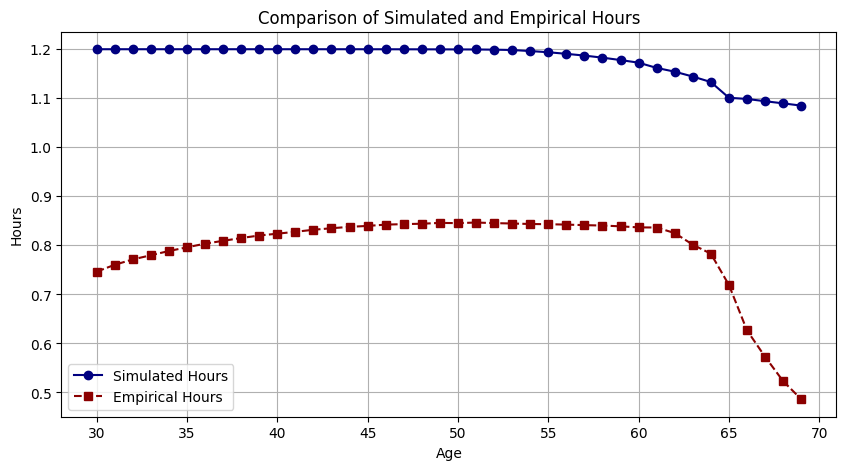

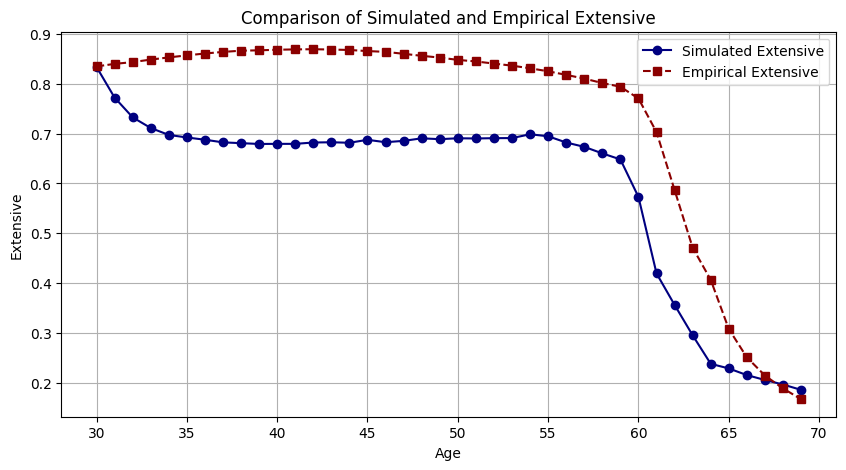

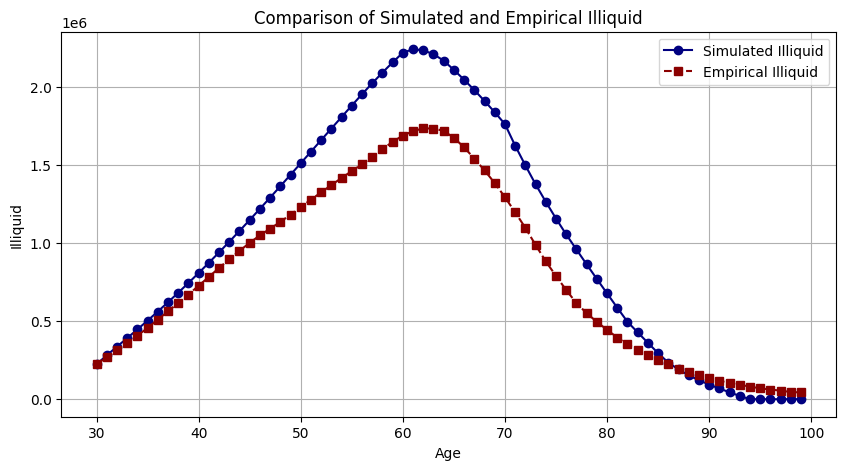

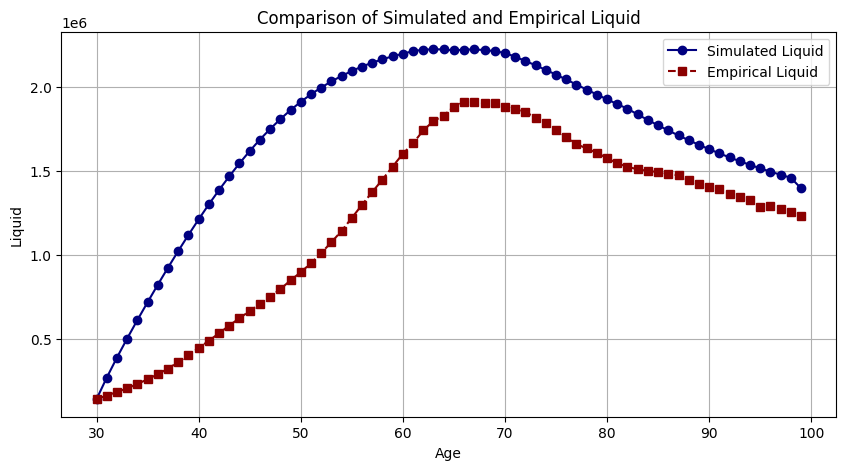

In [ ]:
# plot the graph with calibrated values 
a_dict = {
    'hours': [np.nanmean(np.where(model.sim.ex == 1, model.sim.h, np.nan),axis=0)[:40], moments['hours']],
    'extensive': [np.mean(model.sim.ex, axis=0)[:40], moments['extensive']],
    'illiquid': [np.clip(np.mean(model.sim.s, axis=0), 0, None), moments['savings']],
    'liquid': [np.mean(model.sim.a, axis=0), moments['assets']]
}

# Define colors
simulated_color = "navy"  # Dark blue
empirical_color = "darkred"  # Dark red
ci_color = "lightcoral"  # Light red for confidence bands

for key, (simulated, empirical) in a_dict.items():
    plt.figure(figsize=(10, 5))
    
    x_vals = np.arange(len(empirical)) + par.start_age
    
    plt.plot(x_vals, simulated, label=f"Simulated {key.capitalize()}", marker="o", color=simulated_color)
    plt.plot(x_vals, empirical, label=f"Empirical {key.capitalize()}", linestyle="--", marker="s", color=empirical_color)

    # # 99.9% confidence interval
    # ci = std_dev
    # plt.fill_between(x_vals, empirical - ci, empirical + ci, color=ci_color, alpha=0.4, label="Empirical Standard Deviation")

    plt.xlabel("Age")
    plt.ylabel(key.capitalize())
    plt.title(f"Comparison of Simulated and Empirical {key.capitalize()}")
    plt.legend()
    plt.grid(True)
    plt.show()


Old best variables:

In [ ]:
theta_old = ([0.982, 1.060, 3.877, 7.814, 0.02, 0.009])